In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 29 Lecture 1 Assignment

In this assignment, we will learn about decision trees. We will use the Chicago salary dataset loaded below.

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

<IPython.core.display.Javascript object>

In [4]:
chicago = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Current_Employee_Names__Salaries__and_Position_Titles.csv"
)

<IPython.core.display.Javascript object>

In [5]:
chicago.head()

,Name,Job Titles,Department,Full or Part-Time,Salary or Hourly,Typical Hours,Annual Salary,Hourly Rate
0,"ALLISON, PAUL W",LIEUTENANT,FIRE,F,Salary,NaN,$107790.00,NaN
1,"BRUNO, KEVIN D",SERGEANT,POLICE,F,Salary,NaN,$104628.00,NaN
2,"COOPER, JOHN E",LIEUTENANT-EMT,FIRE,F,Salary,NaN,$114324.00,NaN
3,"CRESPO, VILMA I",STAFF ASST,LAW,F,Salary,NaN,$76932.00,NaN
4,"DOLAN, ROBERT J",SERGEANT,POLICE,F,Salary,NaN,$111474.00,NaN


<IPython.core.display.Javascript object>

To simplify this problem, we will limit our model to only salary employees. Create a new dataset that does not contain any hourly employees.

In [6]:
chicago = chicago[chicago["Salary or Hourly"] == "Salary"]
chicago = chicago.drop(columns=["Salary or Hourly", "Hourly Rate", "Typical Hours"])
chicago.head()

,Name,Job Titles,Department,Full or Part-Time,Annual Salary
0,"ALLISON, PAUL W",LIEUTENANT,FIRE,F,$107790.00
1,"BRUNO, KEVIN D",SERGEANT,POLICE,F,$104628.00
2,"COOPER, JOHN E",LIEUTENANT-EMT,FIRE,F,$114324.00
3,"CRESPO, VILMA I",STAFF ASST,LAW,F,$76932.00
4,"DOLAN, ROBERT J",SERGEANT,POLICE,F,$111474.00


<IPython.core.display.Javascript object>

Next, we will look at the count of all values for both job titles and department to ensure that we don't use features that are too sparse in our model.

In [7]:
# Count job title occurances
job_counts = chicago["Job Titles"].value_counts()
job_counts.tail()

SUPVSR OF CONTRACTS                               1
COMMISSIONER OF STREETS AND SANITATION            1
FIRST DEPUTY CHIEF INFORMATION OFFICER            1
POLICE OFFICER(ASGND AS SUPVG LATENT PRINT EX)    1
DIR OF LIBRARY PERSONNEL                          1
Name: Job Titles, dtype: int64

<IPython.core.display.Javascript object>

In [8]:
# Filter counts to only those above some threshold
# (no good reason to choose 30 here, just an arbitrary number)
keep_job_counts = job_counts[job_counts > 30]
keep_job_counts.tail()

PARAMEDIC FIELD CHIEF                       33
CIVIL ENGINEER IV                           33
ACCOUNTANT III                              32
AIRPORT OPERATIONS SUPVSR I                 32
POLICE OFFICER (ASGND AS MARINE OFFICER)    32
Name: Job Titles, dtype: int64

<IPython.core.display.Javascript object>

In [9]:
# Find the row names (aka index) of the jobs we're keeping
keep_job_titles = keep_job_counts.index
keep_job_titles[:5]

Index(['POLICE OFFICER', 'FIREFIGHTER-EMT', 'SERGEANT',
       'POLICE OFFICER (ASSIGNED AS DETECTIVE)', 'FIREFIGHTER'],
      dtype='object')

<IPython.core.display.Javascript object>

In [10]:
# Perform filtering to only the titles with higher counts
chicago = chicago[chicago["Job Titles"].isin(keep_job_titles)]

<IPython.core.display.Javascript object>

In [11]:
# Repeating same process for dept
dept_counts = chicago["Department"].value_counts()
keep_dept_counts = dept_counts[dept_counts > 30]
keep_depts = keep_dept_counts.index

chicago = chicago[chicago["Department"].isin(keep_depts)]

<IPython.core.display.Javascript object>

In [12]:
chicago.head(2)

,Name,Job Titles,Department,Full or Part-Time,Annual Salary
0,"ALLISON, PAUL W",LIEUTENANT,FIRE,F,$107790.00
1,"BRUNO, KEVIN D",SERGEANT,POLICE,F,$104628.00


<IPython.core.display.Javascript object>

Choose the between department and job title and use the variable with the smallest number of values to for one hot encoding. Additionally, create dummy variables for full ot part-time.

In [13]:
chicago["is_fulltime"] = chicago["Full or Part-Time"] == "F"
chicago["is_fulltime"] = chicago["is_fulltime"].astype(int)

chicago = chicago.drop(columns=["Name", "Job Titles", "Full or Part-Time"])

chicago.head()

,Department,Annual Salary,is_fulltime
0,FIRE,$107790.00,1
1,POLICE,$104628.00,1
2,FIRE,$114324.00,1
3,LAW,$76932.00,1
4,POLICE,$111474.00,1


<IPython.core.display.Javascript object>

Split the data into a test and train sample. Use annual salary as the dependent variable. 20% of the data should be assigned to the test sample.

In [14]:
X = chicago.drop(columns="Annual Salary")

y = chicago["Annual Salary"]
y = pd.to_numeric(y.str.replace("$", ""))

<IPython.core.display.Javascript object>

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [16]:
X_train["Department"].value_counts().head(1)

POLICE    10071
Name: Department, dtype: int64

<IPython.core.display.Javascript object>

In [17]:
cat_cols = ["Department"]
drop_cats = ["POLICE"]

num_cols = []

bin_cols = ["is_fulltime"]

<IPython.core.display.Javascript object>

In [18]:
ct = ColumnTransformer(
    [("one_hot_encode", OneHotEncoder(drop=drop_cats, sparse=False), cat_cols)],
    remainder="passthrough",
)

ct.fit(X_train)

X_train = ct.transform(X_train)
X_test = ct.transform(X_test)

<IPython.core.display.Javascript object>

In [19]:
# # Optionally add back in column names
# cat_names = ct.transformers_[0][1].get_feature_names(cat_cols)
# cat_names = list(cat_names)
# new_col_names = cat_names + num_cols + bin_cols

# X_train = pd.DataFrame(X_train, columns=new_col_names)
# X_test = pd.DataFrame(X_test, columns=new_col_names)

# X_train.head(2)

<IPython.core.display.Javascript object>

Generate a regession decision tree using `DecisionTreeRegressor` in sklearn. Fit the model on the training set and calculate the score for both train and test.

In [20]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

<IPython.core.display.Javascript object>

In [21]:
model.score(X_train, y_train)

0.17121326266847625

<IPython.core.display.Javascript object>

In [22]:
model.score(X_test, y_test)

0.1964973226736767

<IPython.core.display.Javascript object>

Could we use better hyperparameters?

In [23]:
grid = {"min_samples_leaf": [8, 16, 64], "max_depth": [2, 4, 8, 16]}

model_cv = GridSearchCV(DecisionTreeRegressor(), grid)
model_cv.fit(X_train, y_train)

model_cv.best_params_

{'max_depth': 16, 'min_samples_leaf': 8}

<IPython.core.display.Javascript object>

In [24]:
model_cv.score(X_train, y_train)

0.17093232071458742

<IPython.core.display.Javascript object>

In [25]:
model_cv.score(X_test, y_test)

0.1965061117424641

<IPython.core.display.Javascript object>

Train
-------------------
rmse 17137.07
mae 12018.17
mape 0.16


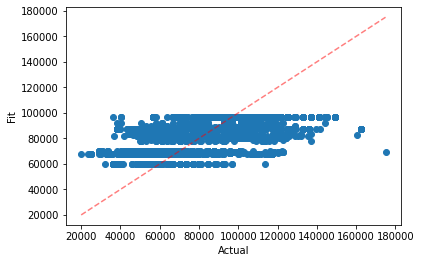

<IPython.core.display.Javascript object>

In [26]:
print("Train\n-------------------")
y_pred = model_cv.predict(X_train)
eval_preds(y_train, y_pred)

Test
-------------------
rmse 16719.21
mae 11906.62
mape 0.16


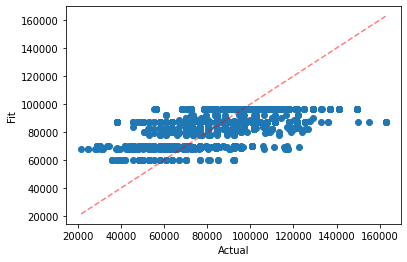

<IPython.core.display.Javascript object>

In [27]:
print("Test\n-------------------")
y_pred = model_cv.predict(X_test)
eval_preds(y_test, y_pred)